## **Lab - RNNs, LSTMs and GRUs**

Repeat the sentiment analysis exercise from Lab 2. For this one you will consider the following models:

- RNN
- LSTM
- GRU
Compare the results with each other and the Naive Bayes model obtained in Lab 2. The group with the best weighted F1 score gets 3 extra points to the final grade, the second best get 2 points, and the third gets 1 point. To simplify, consider only 3 categories: negative, neutral and positive.

To split the data use:

- random_state=13
- test_size=0.2
- stratified split

### **PREPROCESAMIENTO**

#### Cargar dataset y preprocesamiento

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bpnab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bpnab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bpnab\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Archivo cargado exitosamente.


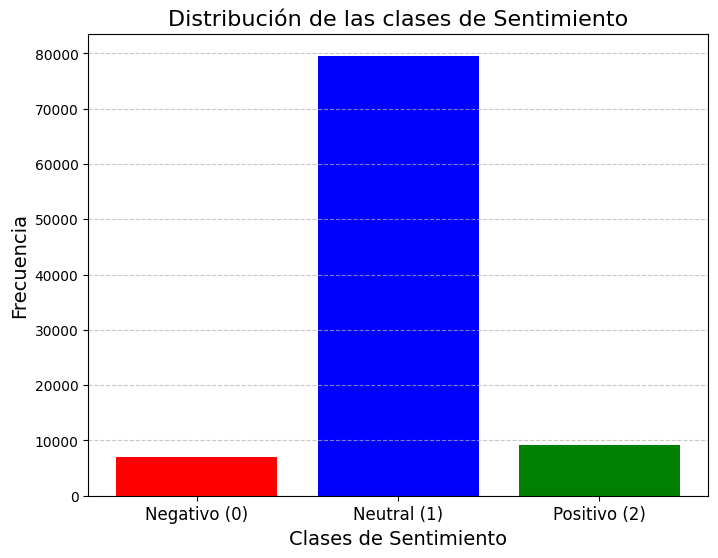

   PhraseId  SentenceId                                             Phrase  \
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   
5         6           1  of escapades demonstrating the adage that what...   

   Sentiment                                      tokens      indexed_tokens  
1          1  [seri, escapad, demonstr, adag, good, goo]  [1, 2, 3, 4, 5, 6]  
2          1                                      [seri]                 [1]  
3          1                                          []                  []  
4          1                                      [seri]                 [1]  
5          1        [escapad, demonstr, adag, good, goo]     [2, 3, 4, 5, 6]  


In [2]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt

# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Cargar el dataset
file_path = r'C:\Users\bpnab\OneDrive - Universidad San Francisco de Quito\USFQ\Clases\8. NLP\lab2\train.tsv'

try:
    # Carga del archivo con manejo de formato TSV
    data = pd.read_csv(file_path, sep='\t', quotechar='"')
    print("Archivo cargado exitosamente.")
except pd.errors.ParserError as e:
    print(f"Error al parsear el archivo: {e}")
    data = pd.DataFrame()  # Crea un DataFrame vacío si hay un error

# Filtrar solo las clases de interés: 0 (negativa), 2 (neutral), 4 (positiva)
data = data[data['Sentiment'].isin([0, 2, 4])]

# Mapear las etiquetas 0 -> 0, 2 -> 1, 4 -> 2
label_mapping = {0: 0, 2: 1, 4: 2}
data['Sentiment'] = data['Sentiment'].map(label_mapping)

# Inicializar stopwords, stemmer y lemmatizer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Función de preprocesamiento
def preprocess_text(text):
    # Case folding (convertir a minúsculas)
    tokens = word_tokenize(text.lower())

    # Eliminar stop words y hacer stemming y lemmatization
    tokens = [lemmatizer.lemmatize(stemmer.stem(word)) for word in tokens if word not in stop_words and word.isalpha()]

    return tokens

# Aplicar preprocesamiento
data['tokens'] = data['Phrase'].apply(preprocess_text)

# Construcción de vocabulario
word_counts = Counter(word for tokens in data['tokens'] for word in tokens)
vocab = {word: i+1 for i, word in enumerate(word_counts)}

# Conversión de tokens a índices
def tokens_to_indices(tokens):
    return [vocab.get(token, 0) for token in tokens]

data['indexed_tokens'] = data['tokens'].apply(tokens_to_indices)

# Gráfico de distribución de clases
class_distribution = data['Sentiment'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(class_distribution.index, class_distribution.values, color=['blue', 'green', 'red'])
plt.title('Distribución de las clases de Sentimiento', fontsize=16)
plt.xlabel('Clases de Sentimiento', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.xticks([0, 1, 2], ['Negativo (0)', 'Neutral (1)', 'Positivo (2)'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

# Mostrar algunas filas para verificar el preprocesamiento
print(data.head())


#### Division

In [4]:
from sklearn.model_selection import train_test_split
# Dividir en conjuntos de entrenamiento y prueba (estratificado)
train_data, test_data = train_test_split(
    data, test_size=0.2, random_state=13, stratify=data['Sentiment']
)



#### Dataloader

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Clase personalizada para el Dataset
class SentimentDataset(Dataset):
    def __init__(self, dataframe):
        self.inputs = dataframe['indexed_tokens'].tolist()
        self.labels = dataframe['Sentiment'].tolist()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        # Asegurarse de que los inputs sean del tipo 'long' y las etiquetas también
        return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

# Función para rellenar secuencias en batch
def collate_fn(batch):
    inputs, labels = zip(*batch)
    # Rellenar secuencias de entrada con padding value = 0
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    # Crear tensor de etiquetas
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return inputs_padded, labels_tensor

# Creación de los DataLoaders
train_dataset = SentimentDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn, num_workers=4, shuffle=True)

test_dataset = SentimentDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn, num_workers=4)


### **RNN**

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAccuracy
import matplotlib.pyplot as plt

# Definir la red RNN para el análisis de sentimientos
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        output = output[:, -1, :]  # Tomar la última salida de la secuencia
        return self.fc(output)

# Función para entrenar el modelo
def train_model(model, train_loader, optimizer, criterion, device, num_epochs):
    model.train()
    history_loss = []
    history_accuracy = []
    
    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0
        total_examples = 0
        accuracy_metric = MulticlassAccuracy(num_classes=3, average='macro').to(device)

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Reiniciar gradientes
            optimizer.zero_grad()

            # Forward
            predictions = model(inputs)
            loss = criterion(predictions, labels)

            # Backward y optimización
            loss.backward()
            optimizer.step()

            # Calcular métricas
            total_loss += loss.item()
            total_correct += accuracy_metric(predictions, labels)
            total_examples += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_correct / len(train_loader)
        history_loss.append(avg_loss)
        history_accuracy.append(avg_accuracy.item())

        print(f"Epoch {epoch+1}/{num_epochs}: Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")

    return history_loss, history_accuracy

# Inicializar modelo y otros componentes
vocab_size = len(vocab) + 1  # Ajustar con tu vocabulario real
model = SentimentRNN(vocab_size, embedding_dim=100, hidden_dim=128, output_dim=3)

# Mover el modelo a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Crear DataLoader para el conjunto de entrenamiento
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn, shuffle=True)

# Entrenar el modelo
num_epochs = 50
history_loss, history_accuracy = train_model(model, train_loader, optimizer, criterion, device, num_epochs)

Epoch 1/50: Loss: 0.5241, Accuracy: 0.3903
Epoch 2/50: Loss: 0.4438, Accuracy: 0.4731
Epoch 3/50: Loss: 0.3940, Accuracy: 0.5282
Epoch 4/50: Loss: 0.3642, Accuracy: 0.5524
Epoch 5/50: Loss: 0.3332, Accuracy: 0.5857
Epoch 6/50: Loss: 0.3037, Accuracy: 0.6650
Epoch 7/50: Loss: 0.2708, Accuracy: 0.7352
Epoch 8/50: Loss: 0.2438, Accuracy: 0.7776
Epoch 9/50: Loss: 0.2214, Accuracy: 0.8061
Epoch 10/50: Loss: 0.1995, Accuracy: 0.8329
Epoch 11/50: Loss: 0.1876, Accuracy: 0.8438
Epoch 12/50: Loss: 0.1803, Accuracy: 0.8511
Epoch 13/50: Loss: 0.1642, Accuracy: 0.8672
Epoch 14/50: Loss: 0.1554, Accuracy: 0.8766
Epoch 15/50: Loss: 0.1475, Accuracy: 0.8823
Epoch 16/50: Loss: 0.1459, Accuracy: 0.8804
Epoch 17/50: Loss: 0.1370, Accuracy: 0.8924
Epoch 18/50: Loss: 0.1417, Accuracy: 0.8820
Epoch 19/50: Loss: 0.1293, Accuracy: 0.8968
Epoch 20/50: Loss: 0.1286, Accuracy: 0.8961
Epoch 21/50: Loss: 0.1172, Accuracy: 0.9071
Epoch 22/50: Loss: 0.1169, Accuracy: 0.9035
Epoch 23/50: Loss: 0.1107, Accuracy: 0.91

In [34]:
# Guardar el modelo
torch.save(model.state_dict(), 'sentiment_rnn.pth')


In [35]:
from torchmetrics.classification import MulticlassF1Score
import numpy as np

# Función para evaluar el modelo en el conjunto de prueba
def evaluate_model(model, test_loader, device):
    model.eval()
    total_correct = 0
    all_labels = []
    all_predictions = []
    accuracy_metric = MulticlassAccuracy(num_classes=3, average='macro').to(device)
    f1_metric = MulticlassF1Score(num_classes=3, average='weighted').to(device)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            total_correct += accuracy_metric(predictions, labels)
            f1_metric(predictions, labels)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.argmax(dim=1).cpu().numpy())

    avg_accuracy = total_correct / len(test_loader)
    avg_f1 = f1_metric.compute()
    print(f"Test Accuracy: {avg_accuracy:.4f}, Test F1 Score (weighted): {avg_f1:.4f}")

    return np.array(all_labels), np.array(all_predictions)

# Crear DataLoader para el conjunto de prueba
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

# Evaluar el modelo en el conjunto de prueba
all_labels, all_predictions = evaluate_model(model, test_loader, device)


Test Accuracy: 0.7212, Test F1 Score (weighted): 0.8959


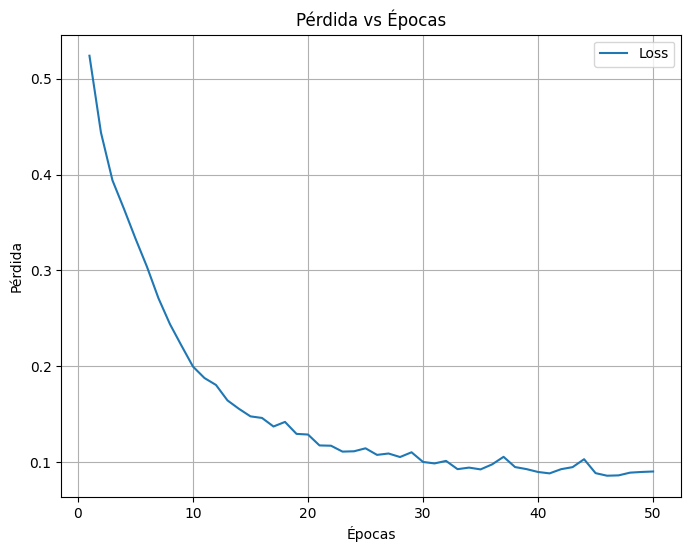

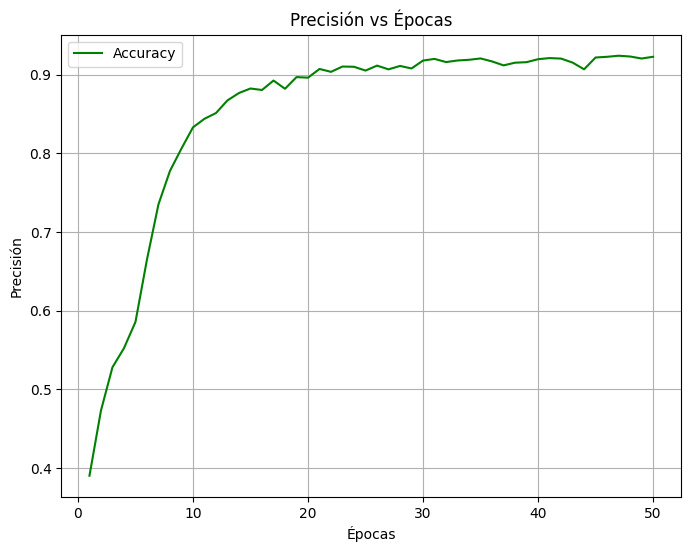

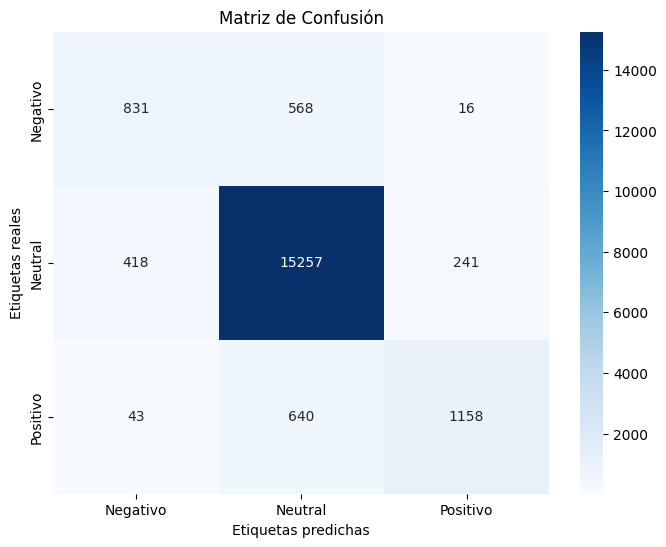

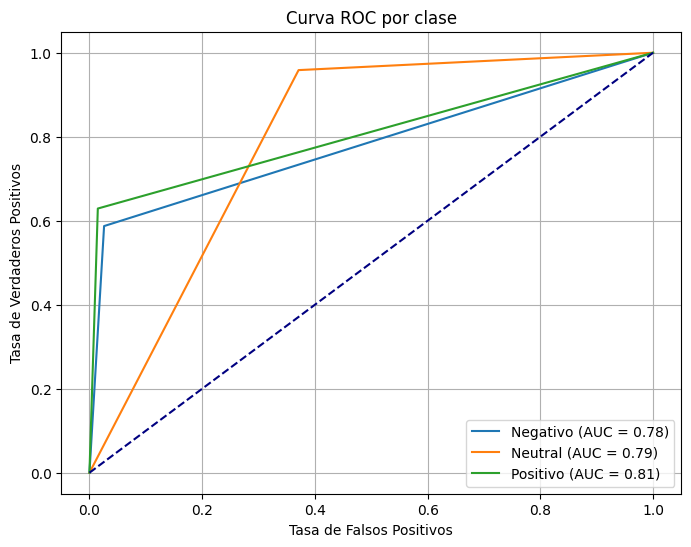

In [36]:
# Graficar loss vs epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), history_loss, label='Loss')
plt.title('Pérdida vs Épocas')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.grid(True)
plt.legend()
plt.show()

# Graficar accuracy vs epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), history_accuracy, label='Accuracy', color='green')
plt.title('Precisión vs Épocas')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.grid(True)
plt.legend()
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negativo', 'Neutral', 'Positivo'], yticklabels=['Negativo', 'Neutral', 'Positivo'])
plt.title('Matriz de Confusión')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')
plt.show()


from sklearn.metrics import roc_curve, auc

# Nombres de las clases
class_names = ['Negativo', 'Neutral', 'Positivo']

# Curva ROC y AUC
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):  # 3 clases
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar la curva ROC para cada clase
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Curva ROC por clase')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### **LSTM**

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAccuracy
import matplotlib.pyplot as plt

# Definir la red RNN para el análisis de sentimientos
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        output = output[:, -1, :]  # Tomar la última salida de la secuencia
        return self.fc(output)

# Función para entrenar el modelo
def train_model(model, train_loader, optimizer, criterion, device, num_epochs):
    model.train()
    history_loss = []
    history_accuracy = []
    
    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0
        total_examples = 0
        accuracy_metric = MulticlassAccuracy(num_classes=3, average='macro').to(device)

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Reiniciar gradientes
            optimizer.zero_grad()

            # Forward
            predictions = model(inputs)
            loss = criterion(predictions, labels)

            # Backward y optimización
            loss.backward()
            optimizer.step()

            # Calcular métricas
            total_loss += loss.item()
            total_correct += accuracy_metric(predictions, labels)
            total_examples += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_correct / len(train_loader)
        history_loss.append(avg_loss)
        history_accuracy.append(avg_accuracy.item())

        print(f"Epoch {epoch+1}/{num_epochs}: Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")

    return history_loss, history_accuracy

# Inicializar modelo y otros componentes
vocab_size = len(vocab) + 1  # Ajustar con tu vocabulario real
model = SentimentLSTM(vocab_size, embedding_dim=100, hidden_dim=128, output_dim=3)

# Mover el modelo a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Crear DataLoader para el conjunto de entrenamiento
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn, shuffle=True)

# Entrenar el modelo
num_epochs = 50
history_loss, history_accuracy = train_model(model, train_loader, optimizer, criterion, device, num_epochs)

Epoch 1/50: Loss: 0.4757, Accuracy: 0.4386
Epoch 2/50: Loss: 0.3427, Accuracy: 0.6199
Epoch 3/50: Loss: 0.2613, Accuracy: 0.7466
Epoch 4/50: Loss: 0.2165, Accuracy: 0.8002
Epoch 5/50: Loss: 0.1848, Accuracy: 0.8322
Epoch 6/50: Loss: 0.1610, Accuracy: 0.8583
Epoch 7/50: Loss: 0.1438, Accuracy: 0.8719
Epoch 8/50: Loss: 0.1294, Accuracy: 0.8888
Epoch 9/50: Loss: 0.1177, Accuracy: 0.8951
Epoch 10/50: Loss: 0.1083, Accuracy: 0.9050
Epoch 11/50: Loss: 0.1006, Accuracy: 0.9127
Epoch 12/50: Loss: 0.0940, Accuracy: 0.9135
Epoch 13/50: Loss: 0.0894, Accuracy: 0.9168
Epoch 14/50: Loss: 0.0825, Accuracy: 0.9233
Epoch 15/50: Loss: 0.0785, Accuracy: 0.9240
Epoch 16/50: Loss: 0.0743, Accuracy: 0.9267
Epoch 17/50: Loss: 0.0732, Accuracy: 0.9292
Epoch 18/50: Loss: 0.0671, Accuracy: 0.9345
Epoch 19/50: Loss: 0.0641, Accuracy: 0.9337
Epoch 20/50: Loss: 0.0643, Accuracy: 0.9314
Epoch 21/50: Loss: 0.0635, Accuracy: 0.9354
Epoch 22/50: Loss: 0.0599, Accuracy: 0.9374
Epoch 23/50: Loss: 0.0567, Accuracy: 0.93

In [38]:
# Guardar el modelo
torch.save(model.state_dict(), 'sentiment_lstm.pth')


In [39]:
from torchmetrics.classification import MulticlassF1Score
import numpy as np

# Función para evaluar el modelo en el conjunto de prueba
def evaluate_model(model, test_loader, device):
    model.eval()
    total_correct = 0
    all_labels = []
    all_predictions = []
    accuracy_metric = MulticlassAccuracy(num_classes=3, average='macro').to(device)
    f1_metric = MulticlassF1Score(num_classes=3, average='weighted').to(device)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            total_correct += accuracy_metric(predictions, labels)
            f1_metric(predictions, labels)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.argmax(dim=1).cpu().numpy())

    avg_accuracy = total_correct / len(test_loader)
    avg_f1 = f1_metric.compute()
    print(f"Test Accuracy: {avg_accuracy:.4f}, Test F1 Score (weighted): {avg_f1:.4f}")

    return np.array(all_labels), np.array(all_predictions)

# Crear DataLoader para el conjunto de prueba
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

# Evaluar el modelo en el conjunto de prueba
all_labels, all_predictions = evaluate_model(model, test_loader, device)


Test Accuracy: 0.7555, Test F1 Score (weighted): 0.9038


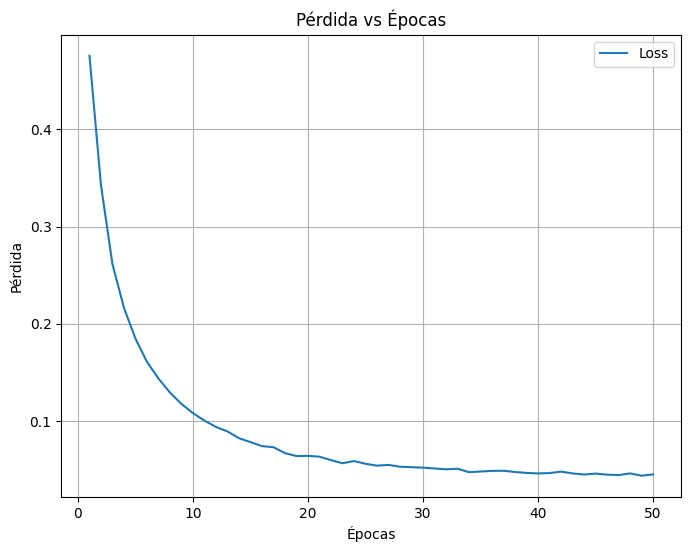

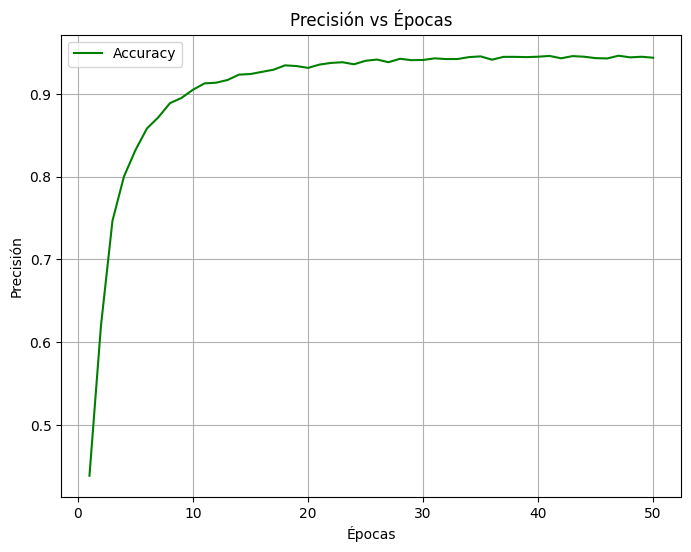

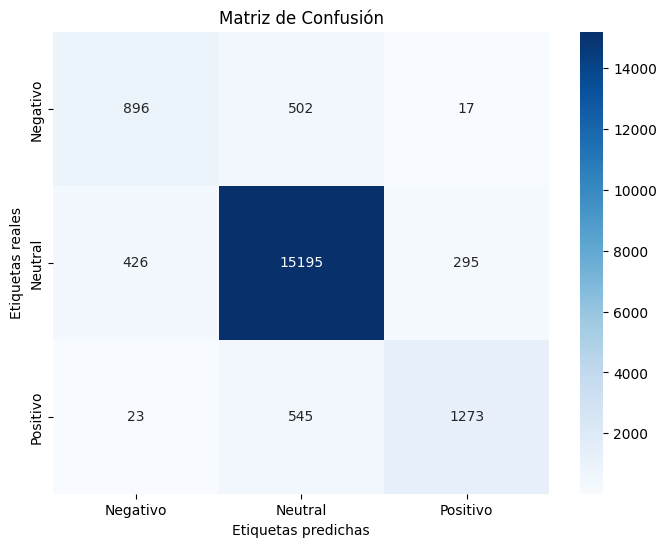

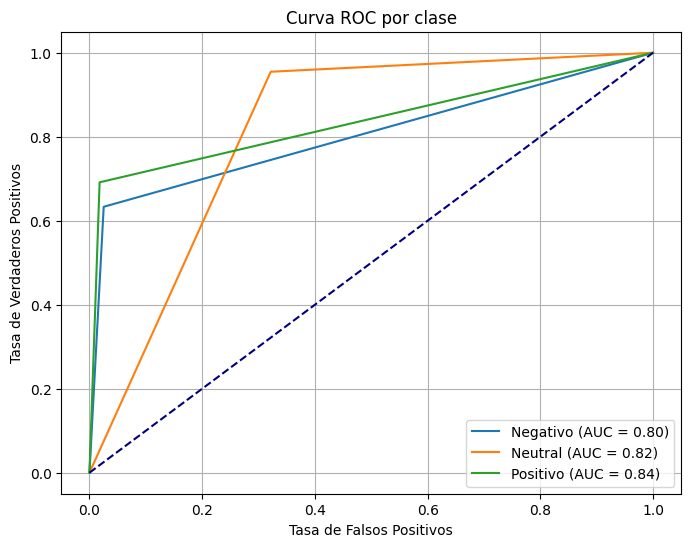

In [40]:
# Graficar loss vs epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), history_loss, label='Loss')
plt.title('Pérdida vs Épocas')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.grid(True)
plt.legend()
plt.show()

# Graficar accuracy vs epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), history_accuracy, label='Accuracy', color='green')
plt.title('Precisión vs Épocas')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.grid(True)
plt.legend()
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negativo', 'Neutral', 'Positivo'], yticklabels=['Negativo', 'Neutral', 'Positivo'])
plt.title('Matriz de Confusión')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')
plt.show()


from sklearn.metrics import roc_curve, auc

# Nombres de las clases
class_names = ['Negativo', 'Neutral', 'Positivo']

# Curva ROC y AUC
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):  # 3 clases
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar la curva ROC para cada clase
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Curva ROC por clase')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### **GRU**

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassAccuracy
import matplotlib.pyplot as plt

# Definir la red RNN para el análisis de sentimientos
class SentimentGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SentimentGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        output = output[:, -1, :]  # Tomar la última salida de la secuencia
        return self.fc(output)

# Función para entrenar el modelo
def train_model(model, train_loader, optimizer, criterion, device, num_epochs):
    model.train()
    history_loss = []
    history_accuracy = []
    
    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0
        total_examples = 0
        accuracy_metric = MulticlassAccuracy(num_classes=3, average='macro').to(device)

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Reiniciar gradientes
            optimizer.zero_grad()

            # Forward
            predictions = model(inputs)
            loss = criterion(predictions, labels)

            # Backward y optimización
            loss.backward()
            optimizer.step()

            # Calcular métricas
            total_loss += loss.item()
            total_correct += accuracy_metric(predictions, labels)
            total_examples += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_correct / len(train_loader)
        history_loss.append(avg_loss)
        history_accuracy.append(avg_accuracy.item())

        print(f"Epoch {epoch+1}/{num_epochs}: Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")

    return history_loss, history_accuracy

# Inicializar modelo y otros componentes
vocab_size = len(vocab) + 1  # Ajustar con tu vocabulario real
model = SentimentGRU(vocab_size, embedding_dim=100, hidden_dim=128, output_dim=3)

# Mover el modelo a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Crear DataLoader para el conjunto de entrenamiento
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn, shuffle=True)

# Entrenar el modelo
num_epochs = 50
history_loss, history_accuracy = train_model(model, train_loader, optimizer, criterion, device, num_epochs)

Epoch 1/50: Loss: 0.4510, Accuracy: 0.4651
Epoch 2/50: Loss: 0.2943, Accuracy: 0.6954
Epoch 3/50: Loss: 0.2253, Accuracy: 0.7832
Epoch 4/50: Loss: 0.1845, Accuracy: 0.8256
Epoch 5/50: Loss: 0.1560, Accuracy: 0.8567
Epoch 6/50: Loss: 0.1355, Accuracy: 0.8750
Epoch 7/50: Loss: 0.1189, Accuracy: 0.8921
Epoch 8/50: Loss: 0.1068, Accuracy: 0.9039
Epoch 9/50: Loss: 0.0977, Accuracy: 0.9153
Epoch 10/50: Loss: 0.0891, Accuracy: 0.9193
Epoch 11/50: Loss: 0.0827, Accuracy: 0.9259
Epoch 12/50: Loss: 0.0781, Accuracy: 0.9284
Epoch 13/50: Loss: 0.0715, Accuracy: 0.9316
Epoch 14/50: Loss: 0.0680, Accuracy: 0.9324
Epoch 15/50: Loss: 0.0670, Accuracy: 0.9343
Epoch 16/50: Loss: 0.0624, Accuracy: 0.9355
Epoch 17/50: Loss: 0.0599, Accuracy: 0.9361
Epoch 18/50: Loss: 0.0590, Accuracy: 0.9349
Epoch 19/50: Loss: 0.0563, Accuracy: 0.9358
Epoch 20/50: Loss: 0.0552, Accuracy: 0.9400
Epoch 21/50: Loss: 0.0563, Accuracy: 0.9354
Epoch 22/50: Loss: 0.0536, Accuracy: 0.9402
Epoch 23/50: Loss: 0.0517, Accuracy: 0.93

In [42]:
# Guardar el modelo
torch.save(model.state_dict(), 'sentiment_gru.pth')


In [43]:
from torchmetrics.classification import MulticlassF1Score
import numpy as np

# Función para evaluar el modelo en el conjunto de prueba
def evaluate_model(model, test_loader, device):
    model.eval()
    total_correct = 0
    all_labels = []
    all_predictions = []
    accuracy_metric = MulticlassAccuracy(num_classes=3, average='macro').to(device)
    f1_metric = MulticlassF1Score(num_classes=3, average='weighted').to(device)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)
            total_correct += accuracy_metric(predictions, labels)
            f1_metric(predictions, labels)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.argmax(dim=1).cpu().numpy())

    avg_accuracy = total_correct / len(test_loader)
    avg_f1 = f1_metric.compute()
    print(f"Test Accuracy: {avg_accuracy:.4f}, Test F1 Score (weighted): {avg_f1:.4f}")

    return np.array(all_labels), np.array(all_predictions)

# Crear DataLoader para el conjunto de prueba
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

# Evaluar el modelo en el conjunto de prueba
all_labels, all_predictions = evaluate_model(model, test_loader, device)


Test Accuracy: 0.7500, Test F1 Score (weighted): 0.9022


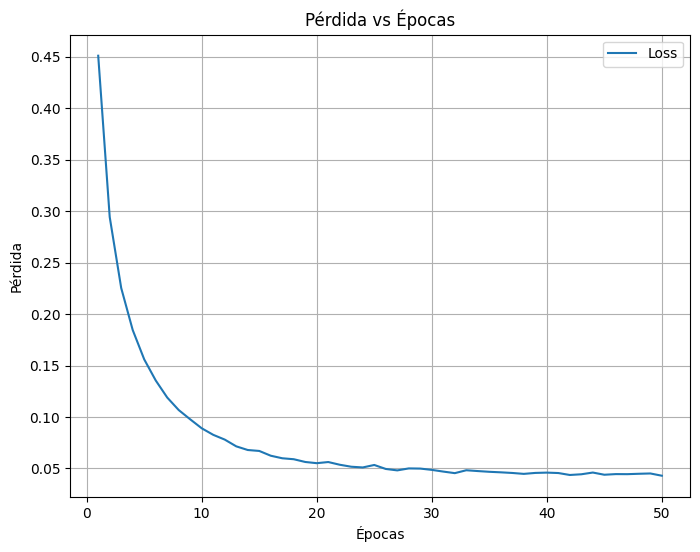

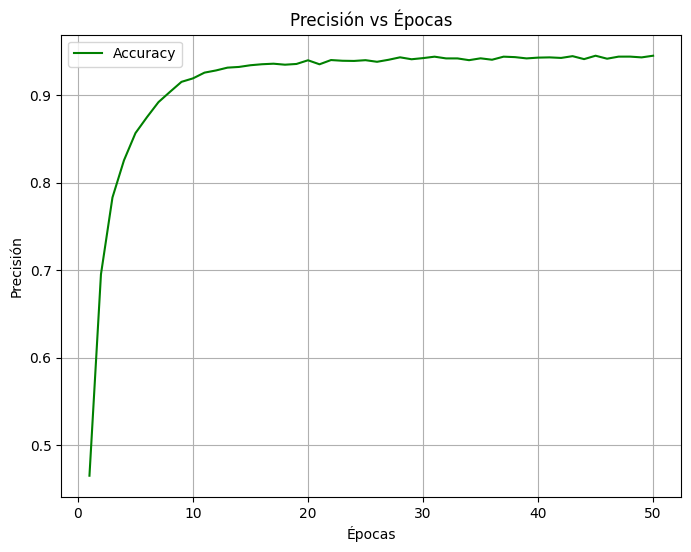

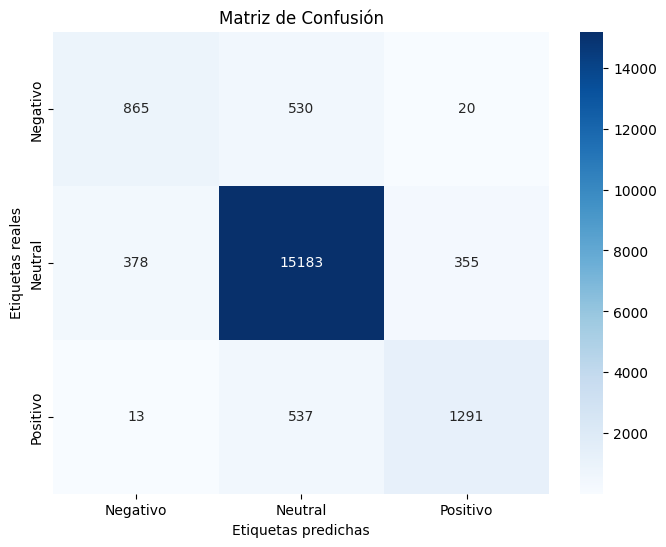

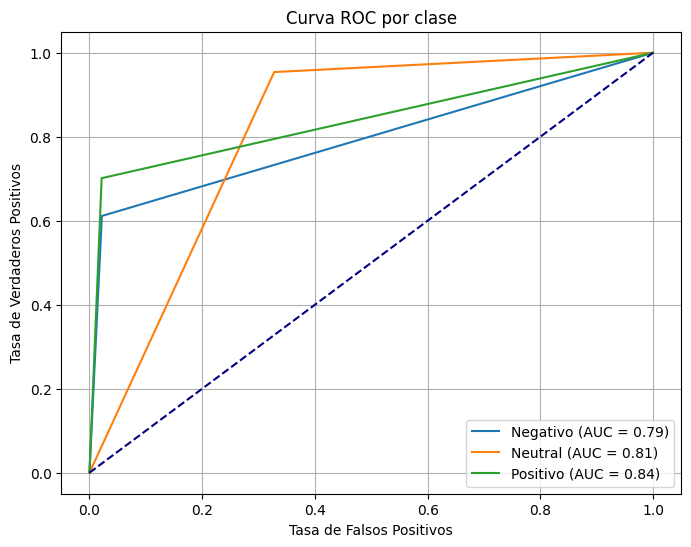

In [44]:
# Graficar loss vs epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), history_loss, label='Loss')
plt.title('Pérdida vs Épocas')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.grid(True)
plt.legend()
plt.show()

# Graficar accuracy vs epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), history_accuracy, label='Accuracy', color='green')
plt.title('Precisión vs Épocas')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.grid(True)
plt.legend()
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negativo', 'Neutral', 'Positivo'], yticklabels=['Negativo', 'Neutral', 'Positivo'])
plt.title('Matriz de Confusión')
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas')
plt.show()


from sklearn.metrics import roc_curve, auc

# Nombres de las clases
class_names = ['Negativo', 'Neutral', 'Positivo']

# Curva ROC y AUC
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):  # 3 clases
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar la curva ROC para cada clase
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Curva ROC por clase')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## **RESULTADOS FINALES**
**RNN:**
-   Test Accuracy: 0.7212, Test F1 Score (weighted): 0.8959

**LSTM:**
-   Test Accuracy: 0.7555, Test F1 Score (weighted): 0.9038

**GRU**:
- Test Accuracy: 0.7500, Test F1 Score (weighted): 0.9022